# Data loading

In [1]:
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
jar1 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling2', 'fuel_swelling3']
jar1.drop(columns=columns_drop, inplace=True)

jar2 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling1', 'fuel_swelling3']
jar2.drop(columns=columns_drop, inplace=True)

jar3 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling1', 'fuel_swelling2']
jar3.drop(columns=columns_drop, inplace=True)

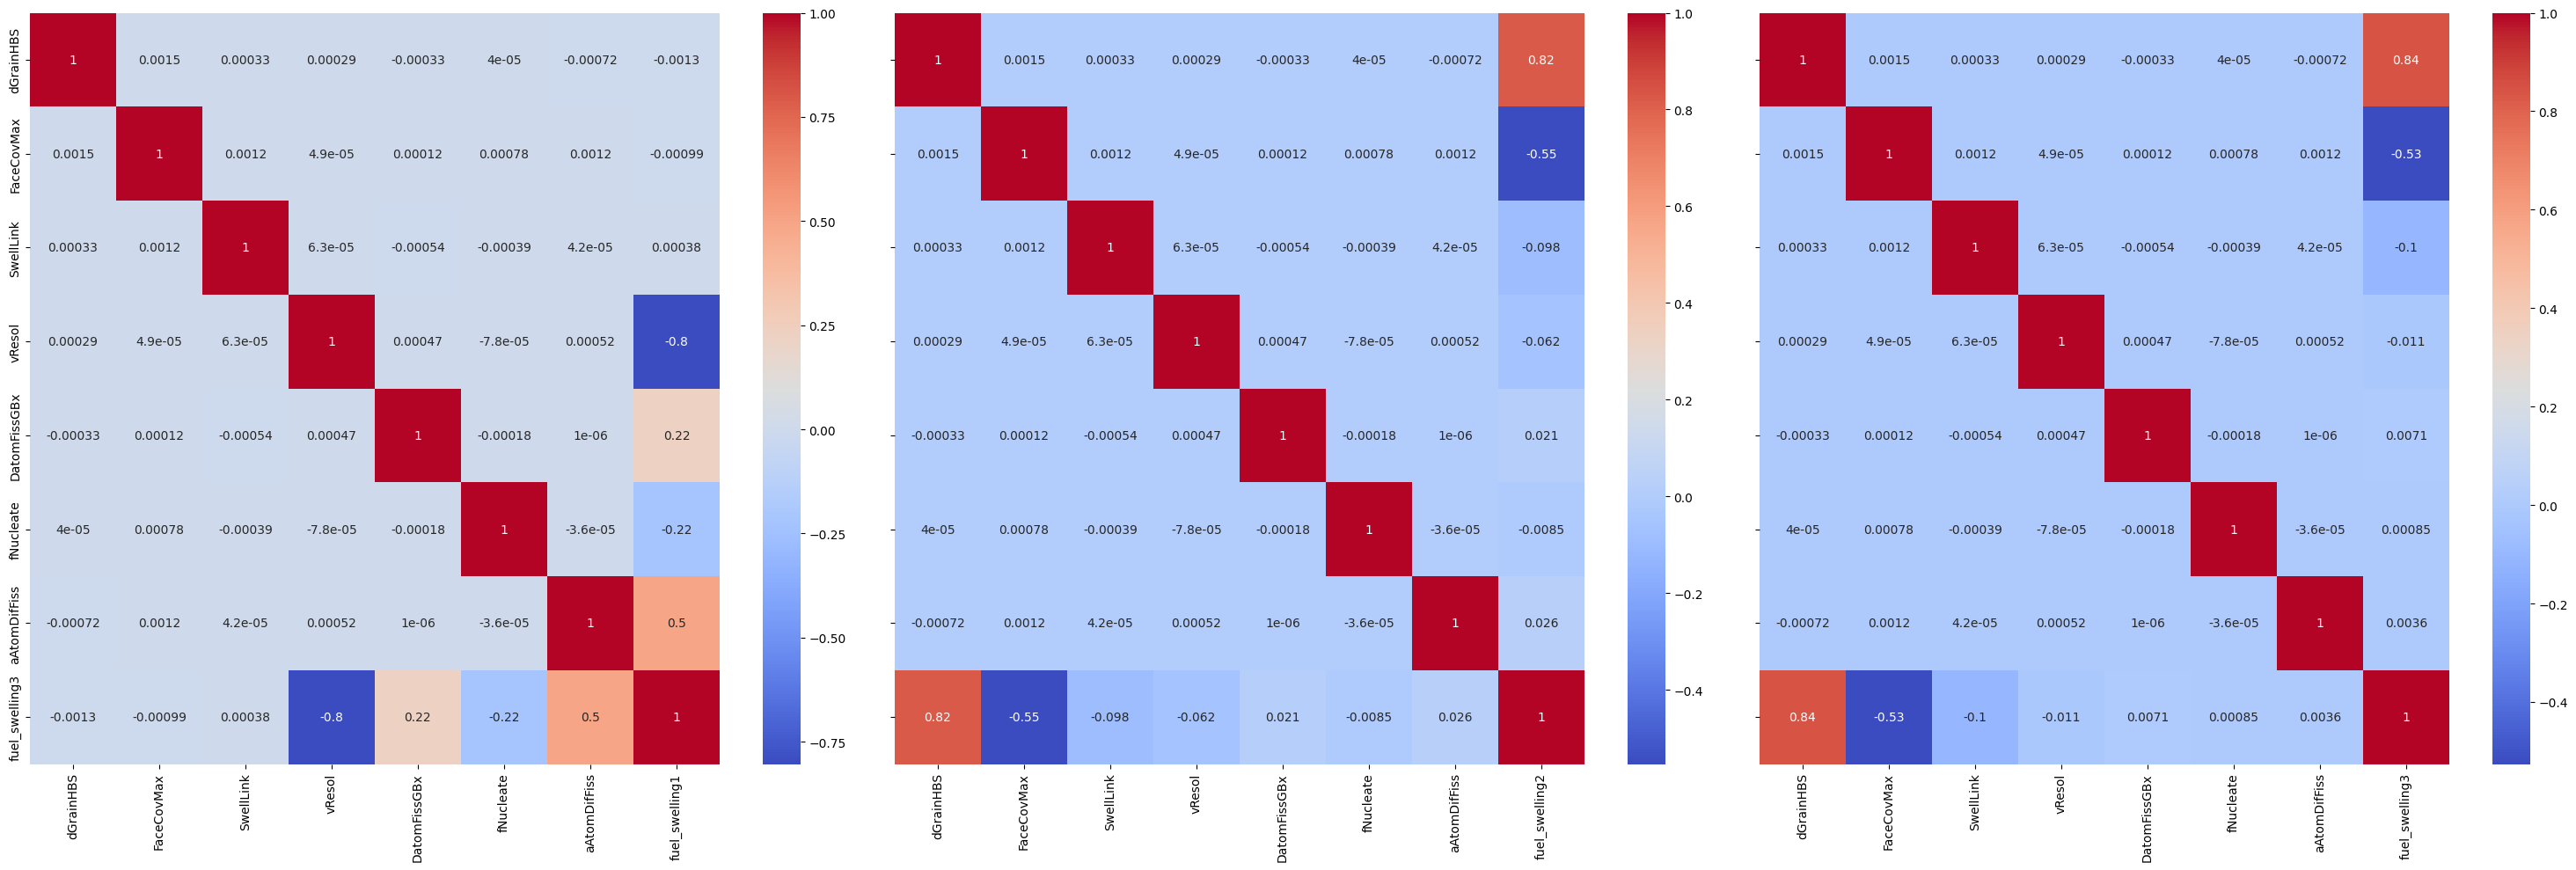

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30, 10))
jar = [jar1, jar2, jar3]

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(jar[i].corr(), ax=ax, annot=True, cmap='coolwarm')

plt.tight_layout()
plt.show()

# Lasso

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [5]:
feat_ind = list(range(7))
features = jar1.iloc[:, feat_ind]
xscaler = StandardScaler()
X = xscaler.fit_transform(features)

In [6]:
y1 = jar1['fuel_swelling1']
y2 = jar2['fuel_swelling2']
y3 = jar3['fuel_swelling3']

In [7]:
reg1 = linear_model.Lasso(alpha=0.0001)
reg2 = linear_model.Lasso(alpha=0.05)
reg3 = linear_model.Lasso(alpha=0.05)

In [8]:
reg1.fit(X, y1)
reg2.fit(X, y2)
reg3.fit(X, y3)

Lasso(alpha=0.05)

In [9]:
print(reg1.score(X, y1),
      reg2.score(X, y2),
      reg3.score(X, y3))

0.9945986202754518 0.9836855077330949 0.9960206085728976


In [10]:
print(reg1.coef_,
      reg2.coef_,
      reg3.coef_)

[-0.         -0.          0.         -0.04141011  0.01134037 -0.01148808
  0.02568774] [ 0.71033701 -0.462806   -0.04027632 -0.00708918  0.         -0.
  0.        ] [ 2.77711992 -1.72138455 -0.30120118 -0.          0.          0.
  0.        ]


# MCMC

In [11]:
def target_dist(x, mu, sig):
    return np.exp(-0.5 * ((x-mu)/sig)**2)

In [12]:
def candidate_dist(x, sig):
    return np.random.normal(x, sig)

In [13]:
def mod_mcmc_sampler(num_param, num_samples, initial_state, proposal_sigma, models):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]

        mus = [10.452, 25.808, 46.068]
        # 2 sig = 15% of the mu => sig = 0.075
        sigs = [xx * 0.075 for xx in mus]

        arr = [0, 1, 2]            # [0,1,2] -> [2,4,6] F_d
        fd_ind = random.choice(arr)
        
        mu = mus[fd_ind]
        sig = sigs[fd_ind]
        model = models[fd_ind]

        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 6              # just to start the loop
            while (abs(proposed_p) > 3):
                proposed_p = candidate_dist(current_p, proposal_sigma)
            #proposed_p = candidate_dist(current_p, proposal_sigma)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p
            theta1 = model.predict([[*current_state]])[0]
            theta2 = model.predict([[*proposed_state]])[0]

            #acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)
            acceptance_ratio = target_dist(theta2, mu, sig) / target_dist(theta1, mu, sig)

            if np.random.rand() < acceptance_ratio and acceptance_ratio != 1:
                current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

In [14]:
regs = [reg1, reg2, reg3]
hey = mod_mcmc_sampler(7, 10000, np.zeros(7), 0.2, regs)

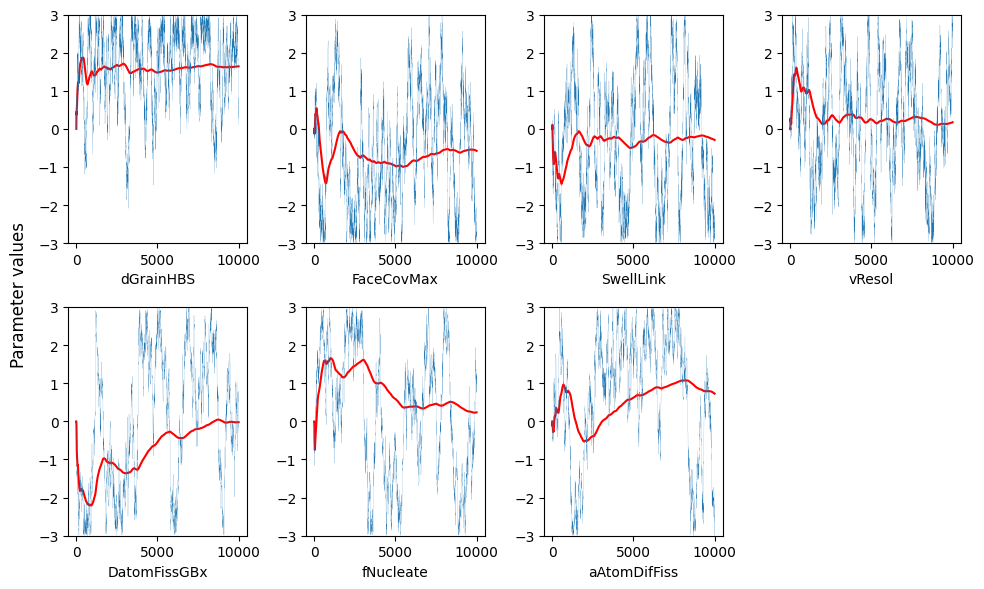

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    cdat = hey[:,i]
    cavg = np.cumsum(cdat) / np.arange(1, len(cdat)+1)
    ax.plot(cavg, c='r')
    ax.plot(cdat, lw=0.1)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

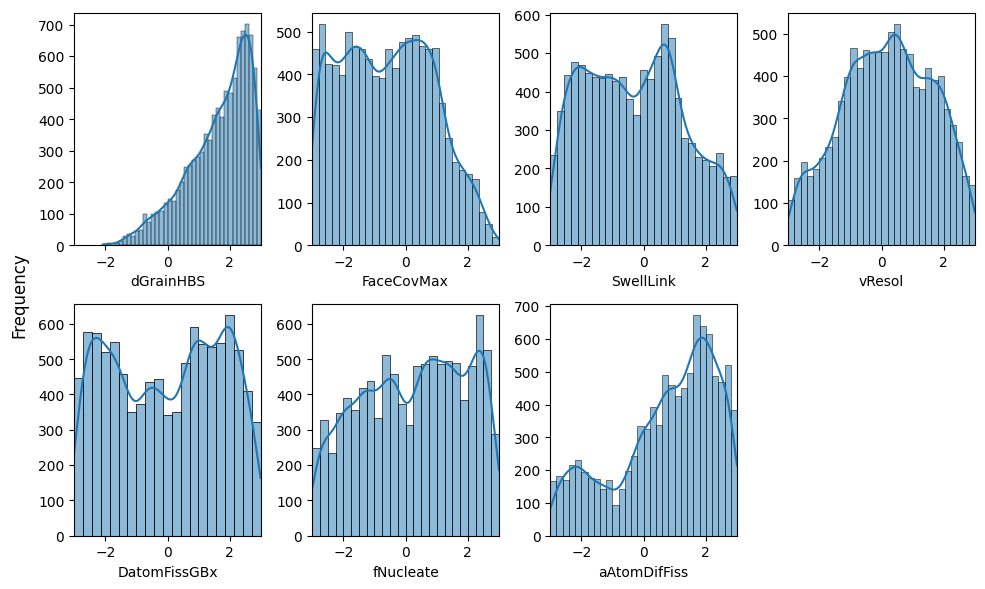

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey[:,i], ax=ax, kde=True)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylabel('')
    ax.set_xlim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Frequency')
plt.tight_layout()
plt.show()

# Forward UQ

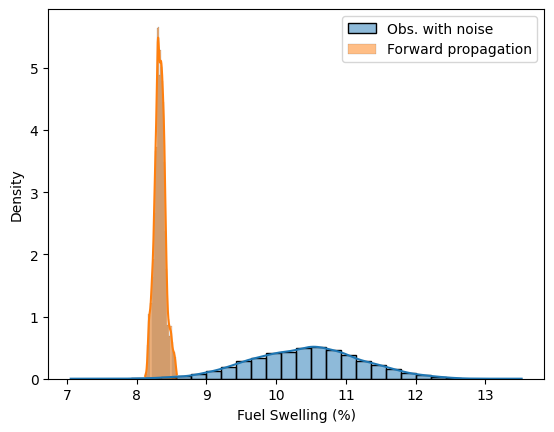

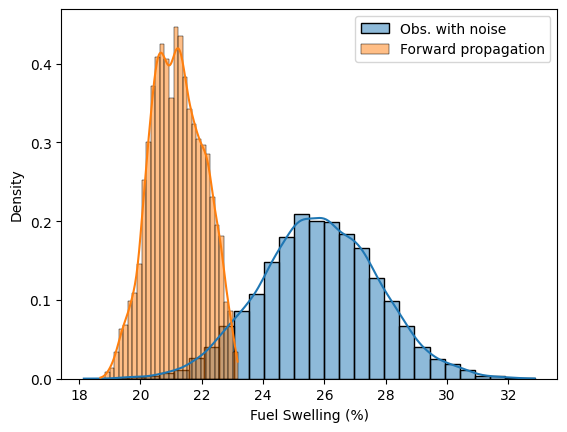

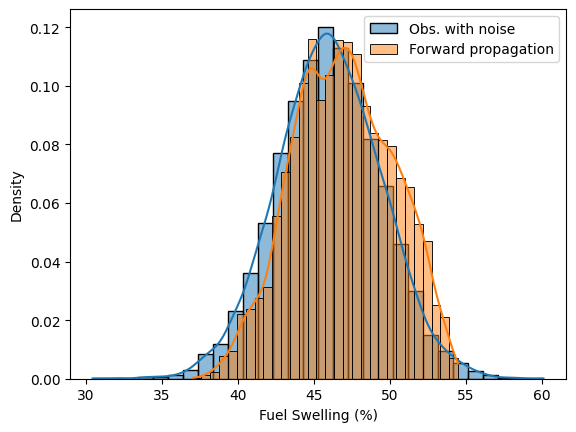

In [17]:
mus = [10.452, 25.808, 46.068]
# 2 sig = 15% of the mu => sig = 0.075
sigs = [xx * 0.075 for xx in mus]

for mod, mu, sig in zip([reg1, reg2, reg3], mus, sigs):
    orig = []
    res = []
    for i in range(10000):
        res.append(mod.predict([hey[-i]])[0])
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fuel Swelling (%)')
    plt.legend()
    plt.show()

# Bias

In [18]:
from statistics import mean, stdev

2.116736310446906 0.7909900225734929


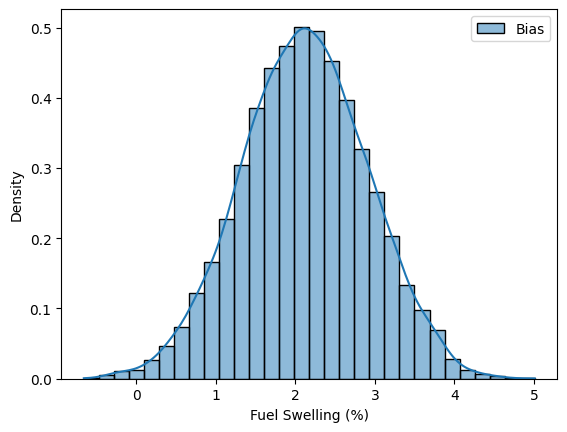

4.610637280231937 2.0946085760003705


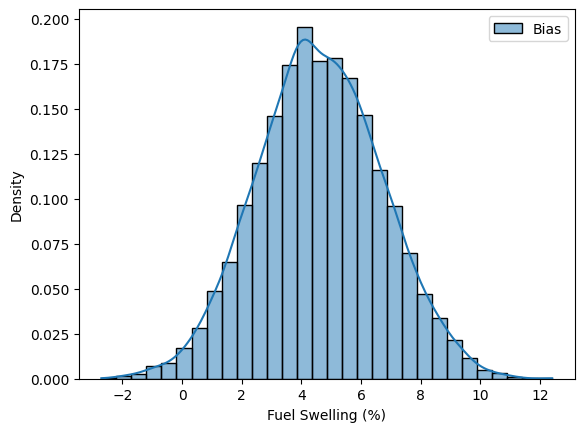

-0.8567508731299334 4.798315503345506


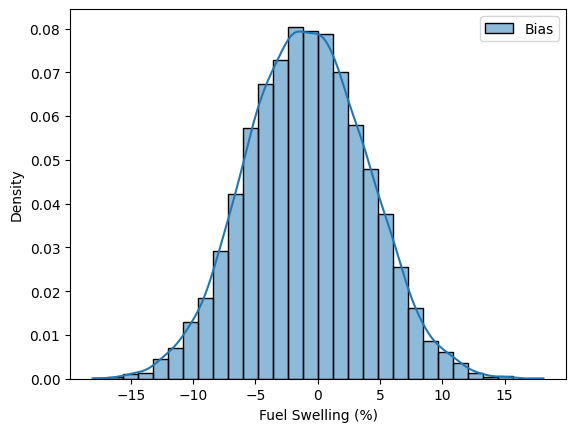

In [19]:
mus = [10.452, 25.808, 46.068]
# 2 sig = 15% of the mu => sig = 0.075
sigs = [xx * 0.075 for xx in mus]

for mod, mu, sig in zip([reg1, reg2, reg3], mus, sigs):
    bias = []
    for i in range(10000):
        p = mod.predict([hey[-i]])[0]
        c = np.random.normal(mu, sig)
        bias.append(c - p)

    print(mean(bias), stdev(bias))
    sns.histplot(bias, kde=True, bins=30, ec='k', stat='density', label='Bias')
    
    plt.xlabel('Fuel Swelling (%)')
    plt.legend()
    plt.show()

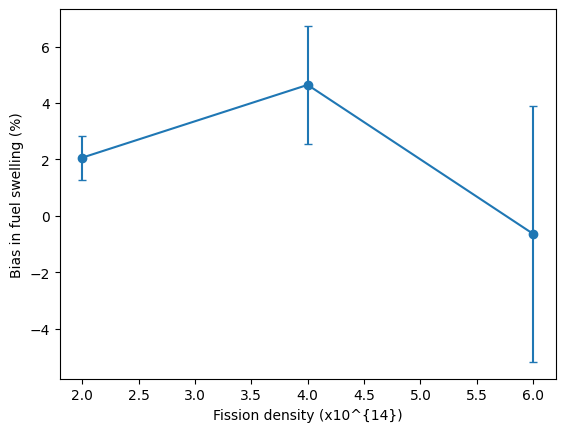

In [20]:
bx = [2, 4, 6]
by = [2.06, 4.64, -0.64]
be = [0.78, 2.09, 4.54]

plt.errorbar(bx, by, be, marker='o', capsize=3)

plt.xlabel('Fission density (x10^{14})')
plt.ylabel('Bias in fuel swelling (%)')
#plt.legend()
plt.show()

# Constant bias

In [21]:
def mod2_mcmc_sampler(num_param, num_samples, initial_state, proposal_sigma, models):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]

        mus = [10.452, 25.808, 46.068]
        # 2 sig = 15% of the mu => sig = 0.075
        sigs = [xx * 0.075 for xx in mus]
        biases = [2.08, 4.81, -0.15]

        arr = [0, 1, 2]            # [0,1,2] -> [2,4,6] F_d
        fd_ind = random.choice(arr)
        
        mu = mus[fd_ind]
        sig = sigs[fd_ind]
        model = models[fd_ind]
        bias = biases[fd_ind]

        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 6              # just to start the loop
            while (abs(proposed_p) > 3):
                proposed_p = candidate_dist(current_p, proposal_sigma)
            #proposed_p = candidate_dist(current_p, proposal_sigma)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p
            theta1 = model.predict([[*current_state]])[0] + bias
            theta2 = model.predict([[*proposed_state]])[0] + bias

            #acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)
            acceptance_ratio = target_dist(theta2, mu, sig) / target_dist(theta1, mu, sig)

            if np.random.rand() < acceptance_ratio and acceptance_ratio != 1:
                current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

In [22]:
regs = [reg1, reg2, reg3]
hey2 = mod2_mcmc_sampler(7, 10000, np.zeros(7), 0.2, regs)

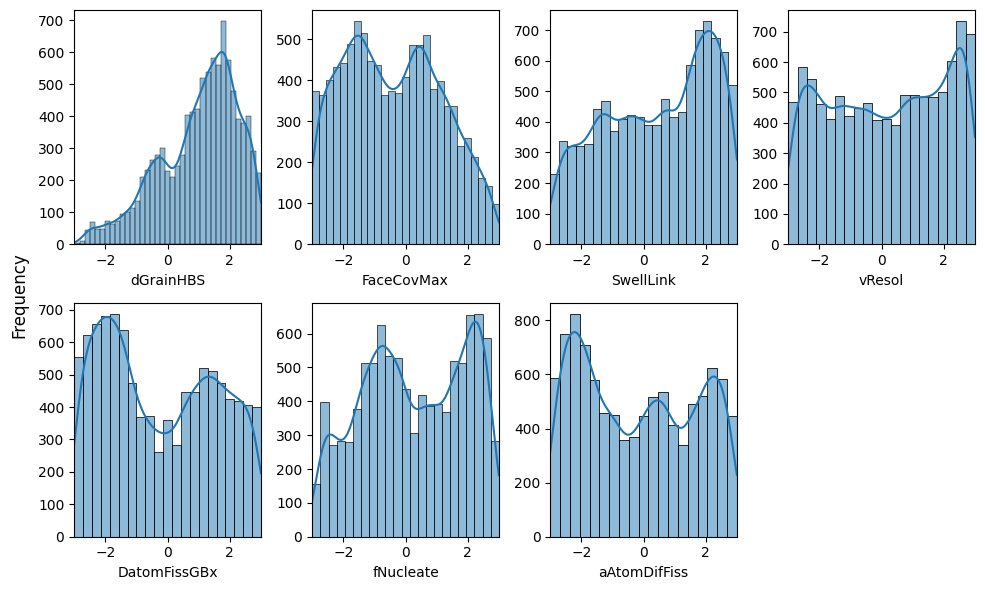

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey2[:,i], ax=ax, kde=True)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylabel('')
    ax.set_xlim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Frequency')
plt.tight_layout()
plt.show()

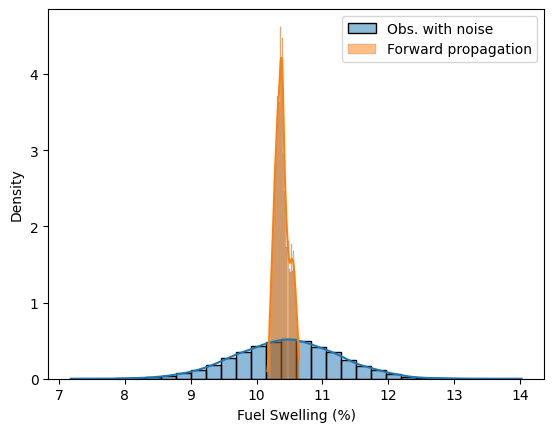

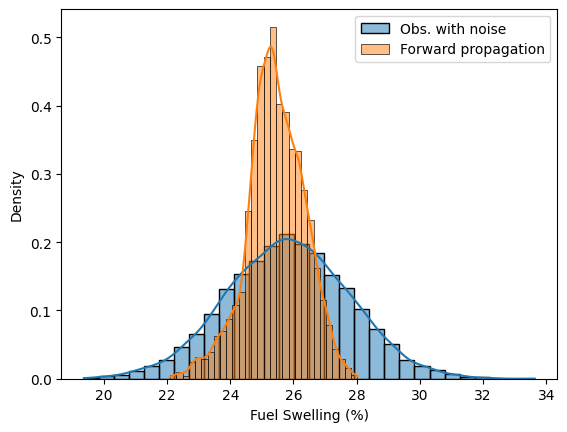

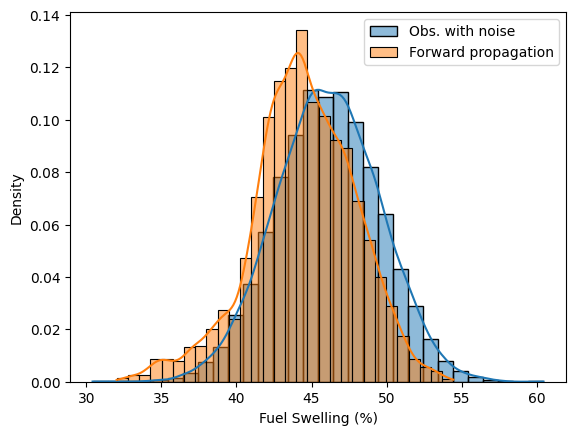

In [24]:
mus = [10.452, 25.808, 46.068]
# 2 sig = 15% of the mu => sig = 0.075
sigs = [xx * 0.075 for xx in mus]
biases = [2.08, 4.81, -0.15]

for mod, mu, sig, bias in zip([reg1, reg2, reg3], mus, sigs, biases):
    orig = []
    res = []
    for i in range(10000):
        res.append(mod.predict([hey2[-i]])[0] + bias)
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fuel Swelling (%)')
    plt.legend()
    plt.show()

# Variable bias

In [25]:
def mod3_mcmc_sampler(num_param, num_samples, initial_state, proposal_sigma, models):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]

        mus = [10.452, 25.808, 46.068]
        # 2 sig = 15% of the mu => sig = 0.075
        sigs = [xx * 0.075 for xx in mus]
        biases = [2.08, 4.81, -0.15]
        bias_devs = [0.78, 2.11, 4.73]

        arr = [0, 1, 2]            # [0,1,2] -> [2,4,6] F_d
        fd_ind = random.choice(arr)
        
        mu = mus[fd_ind]
        sig = sigs[fd_ind]
        model = models[fd_ind]
        bias = biases[fd_ind]
        bias_dev = bias_devs[fd_ind]

        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 6              # just to start the loop
            while (abs(proposed_p) > 3):
                proposed_p = candidate_dist(current_p, proposal_sigma)
            #proposed_p = candidate_dist(current_p, proposal_sigma)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p
            theta1 = model.predict([[*current_state]])[0] + np.random.normal(bias, bias_dev)
            theta2 = model.predict([[*proposed_state]])[0] + np.random.normal(bias, bias_dev)

            #acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)
            acceptance_ratio = target_dist(theta2, mu, sig) / target_dist(theta1, mu, sig)

            if np.random.rand() < acceptance_ratio and acceptance_ratio != 1:
                current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

In [26]:
regs = [reg1, reg2, reg3]
hey3 = mod3_mcmc_sampler(7, 10000, np.zeros(7), 0.2, regs)

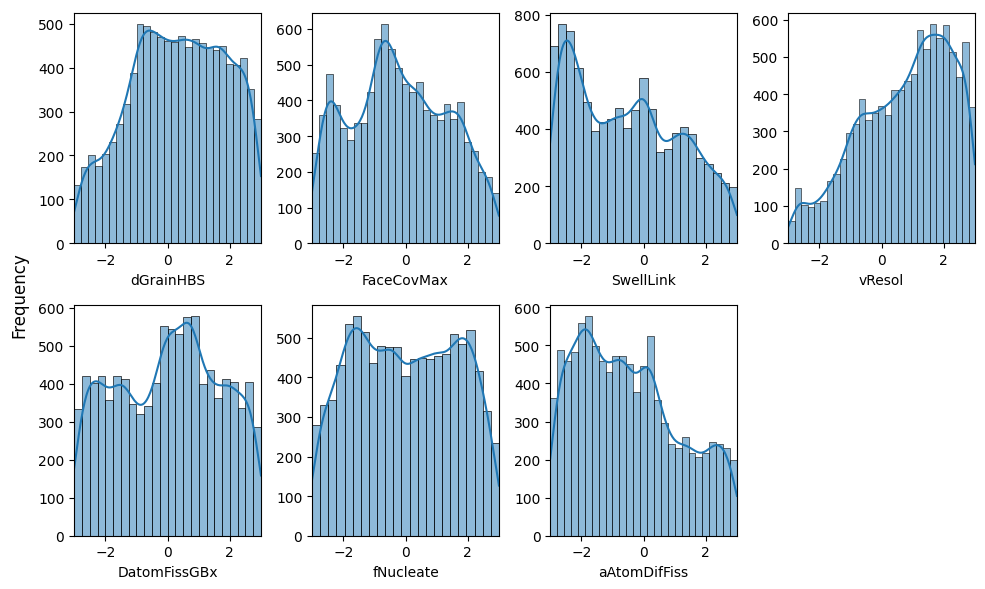

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey3[:,i], ax=ax, kde=True)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylabel('')
    ax.set_xlim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Frequency')
plt.tight_layout()
plt.show()

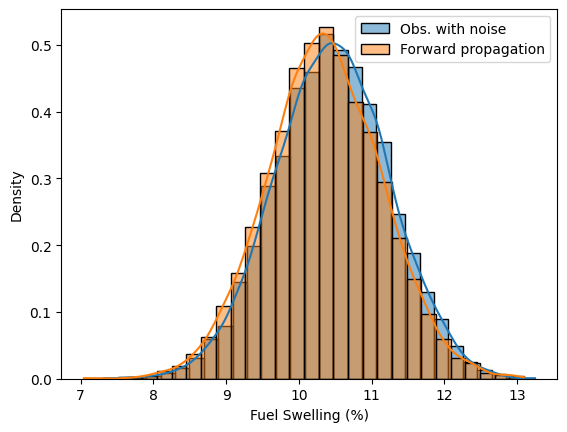

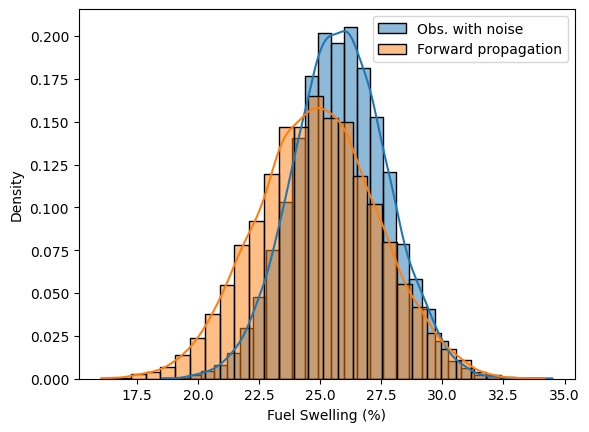

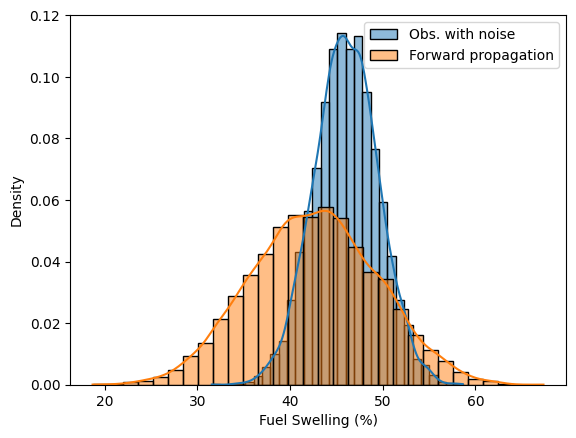

In [28]:
mus = [10.452, 25.808, 46.068]
# 2 sig = 15% of the mu => sig = 0.075
sigs = [xx * 0.075 for xx in mus]
biases = [2.08, 4.81, -0.15]
bias_devs = [0.78, 2.11, 4.73]

for mod, mu, sig, bias, bias_dev in zip([reg1, reg2, reg3], mus, sigs, biases, bias_devs):
    orig = []
    res = []
    for i in range(10000):
        res.append(mod.predict([hey3[-i]])[0] + np.random.normal(bias, bias_dev))
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fuel Swelling (%)')
    plt.legend()
    plt.show()